# Import

In [1]:
from PIL import ImageDraw, ImageFont, Image
import pickle
import numpy as np
from numpy import asarray
import torch
from transformers import ViTImageProcessor,ViTForImageClassification, TrainingArguments

2024-08-11 04:42:12.984190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 04:42:12.984305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 04:42:13.122900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load PKL
- at the same time those array will be convert back to the PIL format

In [176]:
# with open('/kaggle/input/dbsm-cleaned-pkl/kaggle/working/pkl/benign_list/benign_list.pkl', 'rb') as file: #NOTE: this depend on where you locate your pkl files
#     loaded_img_list = pickle.load(file)
    
# benign_list=[]
# x = 0
# while True:
#   try:
#     array_a_loaded = loaded_img_list[x]
#     array_image = Image.fromarray(array_a_loaded) # convert to pil
#     benign_list.append(array_image)
# #     benign_list.append(array_a_loaded)
#     x+=1
#   except:
#     print('end!')
#     break
# print(x)

end!
5368


In [2]:
with open('/kaggle/input/dbsm-cleaned-pkl/kaggle/working/pkl/benign_list/cancer_list.pkl', 'rb') as file:
    loaded_img_list = pickle.load(file)
    
cancer_list=[]
x = 0
while True:
  try:
    array_a_loaded = loaded_img_list[x]
    array_image = Image.fromarray(array_a_loaded) # convert to pil
    cancer_list.append(array_image)
#     cancer_list.append(array_a_loaded)
    x+=1
  except:
    print('end!')
    break
print(x)

end!
5432


In [3]:
with open('/kaggle/input/dbsm-cleaned-pkl/kaggle/working/pkl/benign_list/normal_list.pkl', 'rb') as file:
    loaded_img_list = pickle.load(file)
    
normal_list=[]
x = 0
while True:
  try:
    array_a_loaded = loaded_img_list[x]
    array_image = Image.fromarray(array_a_loaded) # convert to pil
    normal_list.append(array_image)
#     normal_list.append(array_a_loaded)
    x+=1
  except:
    print('end!')
    break
print(x)

end!
4816


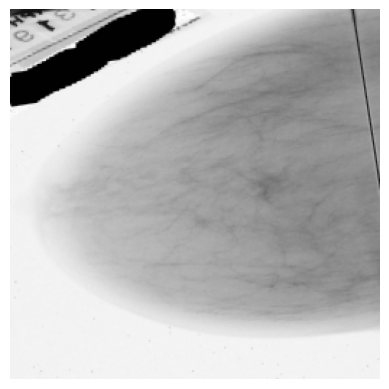

In [71]:
import matplotlib.pyplot as plt

for i in normal_list:
    plt.imshow(i)
    plt.axis('off')
    plt.show
    break

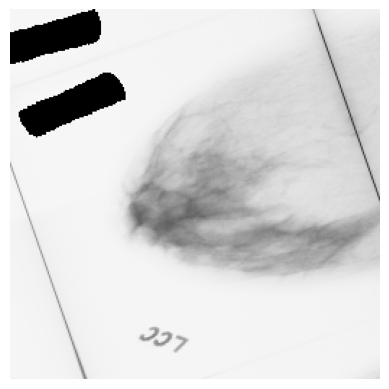

In [72]:
import matplotlib.pyplot as plt

for i in cancer_list:
    plt.imshow(i)
    plt.axis('off')
    plt.show
    break

# Prepare dataset (in img)
- instead of using np array, i directly use image (in pillow format) this didn't crash my kernel

## Loading data into dictionary

In [4]:
# Combine three class into one list (pil data type)
breast_cancer_dataset = normal_list + cancer_list

# forming array label
'''
normal: 0
cancer: 1
benign: 2

'''
# Create label list
labels = (
    [0] * len(normal_list) +   # Create a list of 2's for benign cases
    [1] * len(cancer_list)   # Create a list of 1's for cancer cases
)

In [5]:
# # Combine three class into one list (pil data type)
# breast_cancer_dataset = benign_list + cancer_list + normal_list

# # forming array label
# '''
# normal: 0
# cancer: 1
# benign: 2

# '''
# # Create label list
# labels = (
#     [2] * len(benign_list) +   # Create a list of 2's for benign cases
#     [1] * len(cancer_list) +   # Create a list of 1's for cancer cases
#     [0] * len(normal_list)     # Create a list of 0's for normal cases
# )

In [5]:
from datasets import Dataset, DatasetDict

# Convert data to data dictionary
data_dict = {
    'image': breast_cancer_dataset,  # Convert numpy arrays to list for compatibility
    'labels': labels  # Convert numpy arrays to list for compatibility
}

# Convert dictionary to Hugging Face Dataset
dataset = Dataset.from_dict(data_dict)

# capture train
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
temp_dataset = split['test']

# split test and validation
split_temp = temp_dataset.train_test_split(test_size=0.5)  
val_dataset = split_temp['train']
test_dataset = split_temp['test']

# reformat
breast_cancer_ds = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [6]:
breast_cancer_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 8198
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 1025
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 1025
    })
})

## Prepare processor to transform the data

### using vit-base-bit-224-in21k

In [6]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k' # pretrain name
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

### using google/vit-large-patch16-224

In [30]:
# from transformers import ViTImageProcessor

# model_name_or_path = 'google/vit-large-patch16-224' # pretrain name
# processor = ViTImageProcessor.from_pretrained(model_name_or_path)

### transform

In [7]:
# transform data to compatible with pretrain
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

breast_cancer_ds_cln = breast_cancer_ds.with_transform(transform)

## Setting up ViT pretrain Model + config the model

In [8]:
# training
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


# evaluation
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/tmp/ipykernel_34/906128254.py:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


### using vit-base-bit-224-in21k

In [77]:
# config the labels
from datasets import ClassLabel
from transformers import ViTForImageClassification

labels = ['normal', 'cancer']


model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',  # model name
    num_labels=len(labels),
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: str(i) for i, label in enumerate(labels)},
    device_map='cuda' #NOTE: adding cuda
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### using google/vit-large-patch16-224

In [71]:
# import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ViTForImageClassification.from_pretrained(
#     'google/vit-large-patch16-224',
#     num_labels=len(labels),
#     id2label={str(i): label for i, label in enumerate(labels)},
#     label2id={label: str(i) for i, label in enumerate(labels)},
#     ignore_mismatched_sizes=True
# )

# model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Lin

## Model training

In [78]:
!rm -rf vit-breast-cancer-detection

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [79]:

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

training_args = TrainingArguments(
  output_dir="./vit-breast-cancer-detection",
  per_device_train_batch_size=32,
  evaluation_strategy="steps", 
  num_train_epochs=20, 
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=1e-5, #NOTE
  weight_decay=1e-3, #NOTE
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  overwrite_output_dir=True,
  warmup_steps=100,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [80]:
from transformers import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=6,  # Number of steps with no improvement before stopping
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=breast_cancer_ds_cln["train"],
    eval_dataset=breast_cancer_ds_cln["validation"],
    tokenizer=processor,
    callbacks=[early_stopping_callback],
)


In [81]:
# 9-Aug  (8) using two class (normal and cancer)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Step,Training Loss,Validation Loss,Accuracy
100,0.440100,0.418736,0.834146
200,0.293400,0.318175,0.864390
300,0.220900,0.300352,0.864390
400,0.229300,0.278108,0.878049
500,0.231400,0.263023,0.880976
600,0.220100,0.312465,0.866341
700,0.205400,0.245760,0.887805
800,0.158500,0.268957,0.880000
900,0.152700,0.244713,0.896585
1000,0.127100,0.248119,0.895610


***** train metrics *****
  epoch                    =       5.8366
  total_flos               = 3454779780GF
  train_loss               =       0.2033
  train_runtime            =   0:12:55.43
  train_samples_per_second =      105.722
  train_steps_per_second   =        3.314


## Model Evaluate

In [52]:
metrics = trainer.evaluate(breast_cancer_ds_cln['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =     5.0584
  eval_accuracy           =     0.8985
  eval_loss               =     0.2419
  eval_runtime            = 0:00:08.06
  eval_samples_per_second =    127.159
  eval_steps_per_second   =     16.003


## Confusion matrix

In [53]:
outputs = trainer.predict(breast_cancer_ds_cln['test'])
print(outputs)

PredictionOutput(predictions=array([[-1.296875  ,  1.6025391 ],
       [-1.7724609 ,  1.8623047 ],
       [ 1.4384766 , -1.4882812 ],
       ...,
       [-0.24926758,  0.2705078 ],
       [ 0.46923828, -0.29296875],
       [-1.6757812 ,  1.9052734 ]], dtype=float32), label_ids=array([1, 1, 0, ..., 1, 1, 1]), metrics={'test_loss': 0.22763240337371826, 'test_accuracy': 0.9034146341463415, 'test_runtime': 8.7533, 'test_samples_per_second': 117.099, 'test_steps_per_second': 14.737})


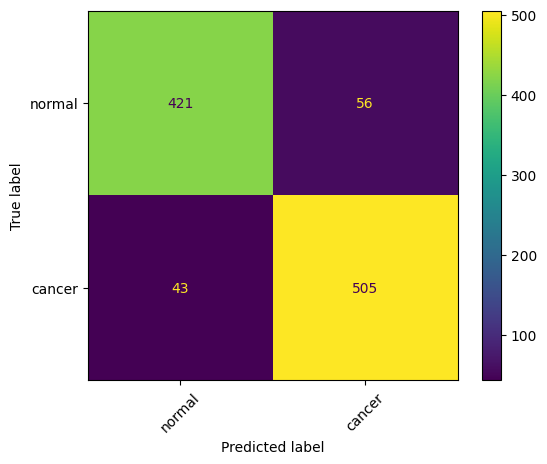

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

'''
normal: 0
cancer: 1
benign: 2

'''

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['normal', 'cancer'])
disp.plot(xticks_rotation=45)

In [55]:
from sklearn.metrics import  classification_report

# table
# Calculate the classification report
report = classification_report(y_true, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

      normal       0.91      0.88      0.89       477
      cancer       0.90      0.92      0.91       548

    accuracy                           0.90      1025
   macro avg       0.90      0.90      0.90      1025
weighted avg       0.90      0.90      0.90      1025



# Model architecture modifying
- in this part we will perform freezing layer on the lower layers
- source point that we shld freeze lower layers that capture generic features [links](https://www.linkedin.com/advice/0/how-can-you-determine-which-layers-freeze-when-okd8f#:~:text=When%20fine%2Dtuning%20a%20pre%2Dtrained%20model%2C%20strategically%20selecting,higher%20layers%20to%20new%20tasks.)

In [65]:
# perform freezing on the first 5 layers
for layer in model.vit.encoder.layer[:5]:  # Freezing the first 10 layers
    for param in layer.parameters():
        param.requires_grad = False

In [12]:
# # view which layer had been freezed
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Frozen: {not param.requires_grad}")



Layer: vit.embeddings.cls_token | Frozen: False
Layer: vit.embeddings.position_embeddings | Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.weight | Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.bias | Frozen: False
Layer: vit.encoder.layer.0.attention.attention.query.weight | Frozen: True
Layer: vit.encoder.layer.0.attention.attention.query.bias | Frozen: True
Layer: vit.encoder.layer.0.attention.attention.key.weight | Frozen: True
Layer: vit.encoder.layer.0.attention.attention.key.bias | Frozen: True
Layer: vit.encoder.layer.0.attention.attention.value.weight | Frozen: True
Layer: vit.encoder.layer.0.attention.attention.value.bias | Frozen: True
Layer: vit.encoder.layer.0.attention.output.dense.weight | Frozen: True
Layer: vit.encoder.layer.0.attention.output.dense.bias | Frozen: True
Layer: vit.encoder.layer.0.intermediate.dense.weight | Frozen: True
Layer: vit.encoder.layer.0.intermediate.dense.bias | Frozen: True
Layer: vit.encoder.layer.0.output.

In [66]:
from transformers import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Wrap the model with DataParallel
# if torch.cuda.device_count() > 1:
#     model = torch.nn.DataParallel(model)

# Initialize the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=6,  # Number of steps with no improvement before stopping
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=breast_cancer_ds_cln["train"],
    eval_dataset=breast_cancer_ds_cln["validation"],
    tokenizer=processor,
    callbacks=[early_stopping_callback],
)


In [67]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Step,Training Loss,Validation Loss,Accuracy
100,0.519600,0.497478,0.801951
200,0.365800,0.381901,0.843902
300,0.293900,0.358575,0.831220
400,0.289000,0.330951,0.838049
500,0.283700,0.313873,0.850732
600,0.255500,0.300714,0.864390
700,0.245800,0.299564,0.855610
800,0.196500,0.291826,0.861463
900,0.208400,0.298440,0.866341
1000,0.179800,0.294279,0.863415


***** train metrics *****
  epoch                    =       7.0039
  total_flos               = 4143859315GF
  train_loss               =       0.2279
  train_runtime            =   0:14:14.72
  train_samples_per_second =       95.914
  train_steps_per_second   =        3.007


## Evaluation

In [15]:
metrics = trainer.evaluate(breast_cancer_ds_cln['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  epoch                   =     6.6148
  eval_accuracy           =     0.8673
  eval_loss               =     0.2892
  eval_runtime            = 0:00:08.08
  eval_samples_per_second =    126.805
  eval_steps_per_second   =     15.959


# Hypertuning

In [ ]:
# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

# # setup config for raytune
# config = {
#     "lr": tune.grid_search([1e-5]),  # learning rates to try
#     "weight_decay": tune.grid_search([0.0])
# }

In [14]:
# function for create new instances
from typing import Dict, Any

def model_init(params: Dict[str, Any]) -> ViTForImageClassification:
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',  # model name
        num_labels=len(labels),
        id2label={str(i): label for i, label in enumerate(labels)},
        label2id={label: str(i) for i, label in enumerate(labels)},
        device_map='cuda' #NOTE: adding cuda
    )
    return model

In [ ]:

# from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# training_args = TrainingArguments(
#   output_dir="./vit-breast-cancer-detection-5",
#   per_device_train_batch_size=32,
#   evaluation_strategy="steps", #NOTE: default is steps
#   num_train_epochs=10, #NOTE
#   fp16=True,
#   save_steps=100,
#   eval_steps=100,
#   logging_steps=10,
#   learning_rate=1e-5, #NOTE
#   weight_decay=0.01, #NOTE
#   save_total_limit=2,
#   remove_unused_columns=False,
#   push_to_hub=False,
#   report_to='tensorboard',
#   load_best_model_at_end=True,
#   overwrite_output_dir=True, #NOTE: overwrite prev weight
# )


In [13]:
# using optuna
from optuna import Trial
from typing import Dict, Union, Any


def hp_space(trial: Trial) -> Dict[str, Union[float, int, str]]:
    params = {
        "body_learning_rate": trial.suggest_categorical("body_learning_rate", 1e-5, 1e-4, log=True),
        "body_weignt_decay": trial.suggest_categorical("body_weignt_decay", 1e-2, 1e-1, log=True),
    }
    training_args = TrainingArguments(
      output_dir="./vit-breast-cancer-detection-5",
      per_device_train_batch_size=32,
      evaluation_strategy="steps", #NOTE: default is steps
      num_train_epochs=10, #NOTE
      fp16=True,
      save_steps=100,
      eval_steps=100,
      logging_steps=10,
      learning_rate=params['body_learning_rate']
      weight_decay=params['body_weight_decay']
      save_total_limit=2,
      remove_unused_columns=False,
      push_to_hub=False,
      report_to='tensorboard',
      load_best_model_at_end=True,
      overwrite_output_dir=True, #NOTE: overwrite prev weight
    )
    return 0.5

In [15]:
from transformers import Trainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=6, 
)

trainer = Trainer(
    model_init=model_init, # must be init to ensure new model instances used
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=breast_cancer_ds_cln["train"],
    eval_dataset=breast_cancer_ds_cln["validation"],
    tokenizer=processor,
    callbacks=[early_stopping_callback],
)

best_run = trainer.hyperparameter_search(direction='maximize',hp_space=hp_space,n_trials=1)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-08-10 02:13:25,062	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[I 2024-08-10 02:13:25,073] A new study created in memory with name: no-name-968127ca-61c2-41dc-a85f-13fa146ac132
Trying to set body_learning_rate in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set body_weignt_decay in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are ne

Step,Training Loss,Validation Loss,Accuracy
100,0.460800,0.433206,0.824390
200,0.321300,0.321386,0.874146
300,0.206300,0.295759,0.874146
400,0.226800,0.292246,0.875122
500,0.274600,0.281154,0.874146
600,0.152800,0.252738,0.890732
700,0.172500,0.247187,0.889756
800,0.174500,0.254326,0.894634
900,0.126300,0.254260,0.892683
1000,0.135300,0.248355,0.895610


[I 2024-08-10 02:24:52,346] Trial 0 finished with value: 0.895609756097561 and parameters: {'body_learning_rate': 9.921826442673876e-05, 'body_weignt_decay': 0.09820737306458914}. Best is trial 0 with value: 0.895609756097561.


In [22]:
import itertools
from transformers import TrainingArguments, Trainer
import torch

# Define your hyperparameter grid
learning_rates = [1e-5, 1e-4, 1e-3]
weight_decays = [1e-3, 1e-2, 1e-1]
warmup_steps = [None, 100, 300, 500]

# Generate all combinations of hyperparameters
hyperparameter_grid = list(itertools.product(learning_rates, weight_decays, warmup_steps))

# Function to perform training and evaluation for a given hyperparameter combination
def train_and_evaluate(learning_rate, weight_decay, warmup_steps):
    training_args = TrainingArguments(
        output_dir="./vit-breast-cancer-detection-5",
        per_device_train_batch_size=32,
        evaluation_strategy="steps",
        num_train_epochs=10,
        fp16=True,
        save_steps=100,
        eval_steps=100,
        logging_steps=10,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True,
        overwrite_output_dir=True,
        warmup_steps=warmup_steps if warmup_steps is not None else 0,  # Handle warmup_steps conditionally
    )

    trainer = Trainer(
        model_init=model_init,  # Ensure new model instances are used
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=breast_cancer_ds_cln["train"],
        eval_dataset=breast_cancer_ds_cln["validation"],
        tokenizer=processor,
        callbacks=[early_stopping_callback],
    )

    # Train and evaluate the model
    trainer.train()
    eval_results = trainer.evaluate()
    
    # Return the evaluation metric you are interested in
    return eval_results['eval_accuracy']  # or any other metric

# Perform grid search
best_score = -float('inf')
best_params = None

for learning_rate, weight_decay, warmup_steps in hyperparameter_grid:
    print(f"Evaluating learning_rate={learning_rate}, weight_decay={weight_decay}, warmup_steps={warmup_steps}")
    score = train_and_evaluate(learning_rate, weight_decay, warmup_steps)
    print(f"Score: {score}")

    if score > best_score:
        best_score = score
        best_params = (learning_rate, weight_decay, warmup_steps)

print(f"Best Score: {best_score}")
print(f"Best Parameters: learning_rate={best_params[0]}, weight_decay={best_params[1]}, warmup_steps={best_params[2]}")


Evaluating learning_rate=1e-05, weight_decay=0.001, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.463400,0.433871,0.821463
200,0.324400,0.322628,0.876098
300,0.207500,0.292235,0.875122
400,0.233300,0.295437,0.869268
500,0.272400,0.279089,0.878049
600,0.150900,0.253456,0.888780
700,0.177000,0.262673,0.883902
800,0.155700,0.268568,0.889756
900,0.125700,0.267319,0.900488
1000,0.135200,0.248159,0.896585


Score: 0.8965853658536586
Evaluating learning_rate=1e-05, weight_decay=0.001, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.568200,0.543276,0.785366
200,0.345400,0.346758,0.869268
300,0.224500,0.303002,0.870244
400,0.240300,0.297452,0.871220
500,0.276400,0.286144,0.872195
600,0.164800,0.266696,0.881951
700,0.164700,0.258477,0.894634
800,0.152200,0.266126,0.888780
900,0.118700,0.268774,0.896585
1000,0.118800,0.246934,0.905366


Score: 0.9053658536585366
Evaluating learning_rate=1e-05, weight_decay=0.001, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.657200,0.652462,0.699512
200,0.480800,0.467443,0.828293
300,0.291800,0.337729,0.862439
400,0.286100,0.317347,0.866341
500,0.296100,0.300561,0.873171
600,0.189000,0.268159,0.885854
700,0.189500,0.268926,0.884878
800,0.184800,0.260701,0.885854
900,0.144400,0.270858,0.890732
1000,0.144300,0.233302,0.901463


Score: 0.9014634146341464
Evaluating learning_rate=1e-05, weight_decay=0.001, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.672400,0.672686,0.633171
200,0.571800,0.558801,0.797073
300,0.382000,0.404128,0.852683
400,0.329800,0.349122,0.858537
500,0.337500,0.320096,0.861463
600,0.212300,0.289146,0.875122
700,0.223100,0.268499,0.877073
800,0.197000,0.263452,0.889756
900,0.155100,0.259072,0.886829
1000,0.177900,0.227969,0.902439


Score: 0.9024390243902439
Evaluating learning_rate=1e-05, weight_decay=0.01, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.461100,0.433744,0.817561
200,0.319900,0.321048,0.872195
300,0.206700,0.292417,0.877073
400,0.232100,0.296746,0.866341
500,0.269400,0.275857,0.874146
600,0.152200,0.252092,0.888780
700,0.168600,0.247715,0.896585
800,0.157400,0.251369,0.893659
900,0.131200,0.259433,0.897561
1000,0.151800,0.253890,0.903415


Score: 0.8965853658536586
Evaluating learning_rate=1e-05, weight_decay=0.01, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.567400,0.542883,0.786341
200,0.348100,0.348687,0.864390
300,0.223800,0.303716,0.871220
400,0.241900,0.299482,0.867317
500,0.274900,0.282565,0.875122
600,0.165700,0.269048,0.883902
700,0.162200,0.256308,0.891707
800,0.160000,0.254062,0.897561
900,0.115200,0.264494,0.891707
1000,0.128500,0.253502,0.902439


Score: 0.9024390243902439
Evaluating learning_rate=1e-05, weight_decay=0.01, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.657100,0.652411,0.700488
200,0.480500,0.467429,0.829268
300,0.293100,0.337200,0.860488
400,0.278700,0.314504,0.870244
500,0.298900,0.304304,0.867317
600,0.186300,0.272833,0.880000
700,0.200000,0.266154,0.883902
800,0.179000,0.265990,0.889756
900,0.133300,0.263387,0.892683
1000,0.145300,0.238576,0.902439


Score: 0.9024390243902439
Evaluating learning_rate=1e-05, weight_decay=0.01, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.672500,0.672706,0.633171
200,0.571900,0.559076,0.796098
300,0.381400,0.403457,0.853659
400,0.329500,0.345509,0.861463
500,0.336400,0.323042,0.859512
600,0.210200,0.290664,0.876098
700,0.219000,0.265012,0.881951
800,0.199100,0.261157,0.890732
900,0.157300,0.256971,0.891707
1000,0.172600,0.234887,0.899512


Score: 0.8995121951219512
Evaluating learning_rate=1e-05, weight_decay=0.1, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.460800,0.433096,0.824390
200,0.325000,0.322298,0.877073
300,0.207000,0.292950,0.880976
400,0.224700,0.284779,0.873171
500,0.273600,0.270115,0.880000
600,0.151900,0.255365,0.887805
700,0.172700,0.255782,0.884878
800,0.163200,0.255060,0.893659
900,0.119000,0.266323,0.901463
1000,0.124000,0.235986,0.904390


Score: 0.904390243902439
Evaluating learning_rate=1e-05, weight_decay=0.1, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.567700,0.542398,0.785366
200,0.347400,0.349711,0.861463
300,0.226300,0.303996,0.867317
400,0.246700,0.303664,0.867317
500,0.277700,0.290268,0.871220
600,0.164900,0.265180,0.880000
700,0.167700,0.258457,0.890732
800,0.162300,0.260813,0.889756
900,0.122000,0.270666,0.894634
1000,0.126900,0.251392,0.900488


Score: 0.9004878048780488
Evaluating learning_rate=1e-05, weight_decay=0.1, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.657300,0.652472,0.698537
200,0.480300,0.469522,0.823415
300,0.292400,0.337233,0.860488
400,0.273400,0.308074,0.870244
500,0.304800,0.293854,0.874146
600,0.187900,0.264079,0.880000
700,0.196300,0.268384,0.883902
800,0.179600,0.262647,0.882927
900,0.139400,0.259997,0.889756
1000,0.152400,0.234139,0.900488


Score: 0.9004878048780488
Evaluating learning_rate=1e-05, weight_decay=0.1, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.672400,0.672711,0.632195
200,0.571900,0.559330,0.798049
300,0.382100,0.403795,0.845854
400,0.333700,0.349221,0.858537
500,0.336700,0.322623,0.863415
600,0.211200,0.285626,0.875122
700,0.221000,0.268633,0.881951
800,0.197900,0.256841,0.892683
900,0.160800,0.258869,0.895610
1000,0.169600,0.234001,0.895610


Score: 0.895609756097561
Evaluating learning_rate=0.0001, weight_decay=0.001, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.315800,0.353632,0.835122
200,0.290100,0.343186,0.849756
300,0.223200,0.280164,0.870244
400,0.209700,0.265804,0.882927
500,0.253500,0.247859,0.891707
600,0.119500,0.322059,0.877073
700,0.178800,0.338840,0.865366
800,0.066700,0.318503,0.884878
900,0.092200,0.346411,0.877073
1000,0.086400,0.314174,0.870244


Score: 0.8917073170731707
Evaluating learning_rate=0.0001, weight_decay=0.001, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.347700,0.379222,0.822439
200,0.312600,0.364002,0.832195
300,0.238000,0.296813,0.857561
400,0.216400,0.274143,0.879024
500,0.299400,0.268373,0.870244
600,0.136200,0.307963,0.885854
700,0.160500,0.261850,0.880000
800,0.046900,0.366926,0.882927
900,0.086200,0.382479,0.878049
1000,0.095700,0.363616,0.870244


Score: 0.88
Evaluating learning_rate=0.0001, weight_decay=0.001, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.414300,0.389168,0.834146
200,0.315500,0.372152,0.828293
300,0.258400,0.348318,0.831220
400,0.206400,0.329458,0.850732
500,0.330100,0.331946,0.835122
600,0.206600,0.268807,0.871220
700,0.183000,0.296179,0.863415
800,0.064400,0.395456,0.871220
900,0.079400,0.333353,0.870244
1000,0.111400,0.314747,0.868293


Score: 0.871219512195122
Evaluating learning_rate=0.0001, weight_decay=0.001, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.466900,0.431128,0.818537
200,0.316200,0.299586,0.859512
300,0.272800,0.320729,0.863415
400,0.230700,0.289563,0.878049
500,0.314300,0.338159,0.834146
600,0.182700,0.278553,0.873171
700,0.188300,0.269277,0.881951
800,0.107400,0.314953,0.874146
900,0.132600,0.273318,0.888780
1000,0.119800,0.319511,0.875122


Score: 0.8819512195121951
Evaluating learning_rate=0.0001, weight_decay=0.01, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.360900,0.352849,0.825366
200,0.312800,0.295178,0.863415
300,0.215100,0.259226,0.880000
400,0.228400,0.267251,0.877073
500,0.254100,0.253035,0.884878
600,0.127100,0.294195,0.873171
700,0.151600,0.269550,0.876098
800,0.048100,0.306685,0.880000
900,0.075300,0.334826,0.881951
1000,0.119700,0.349076,0.884878


Score: 0.8848780487804878
Evaluating learning_rate=0.0001, weight_decay=0.01, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.340100,0.387011,0.800976
200,0.305100,0.308357,0.851707
300,0.228000,0.281311,0.873171
400,0.208300,0.279028,0.866341
500,0.291500,0.257251,0.873171
600,0.130800,0.280775,0.876098
700,0.191000,0.289604,0.881951
800,0.080700,0.282288,0.889756
900,0.097200,0.352347,0.876098
1000,0.087000,0.299495,0.893659


Score: 0.8731707317073171
Evaluating learning_rate=0.0001, weight_decay=0.01, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.411300,0.397557,0.831220
200,0.316800,0.372320,0.813659
300,0.272300,0.306983,0.855610
400,0.233700,0.274329,0.867317
500,0.274700,0.307575,0.847805
600,0.173800,0.315972,0.855610
700,0.164400,0.252296,0.877073
800,0.082200,0.329389,0.873171
900,0.110600,0.316428,0.882927
1000,0.088600,0.310099,0.880976


Score: 0.8770731707317073
Evaluating learning_rate=0.0001, weight_decay=0.01, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.469500,0.434236,0.809756
200,0.322800,0.295198,0.868293
300,0.267000,0.342356,0.839024
400,0.230200,0.279205,0.878049
500,0.352200,0.324718,0.847805
600,0.202700,0.303582,0.875122
700,0.181400,0.280586,0.874146
800,0.132300,0.313343,0.869268
900,0.106800,0.298199,0.870244
1000,0.179400,0.309434,0.877073


Score: 0.8780487804878049
Evaluating learning_rate=0.0001, weight_decay=0.1, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.353800,0.345816,0.834146
200,0.314600,0.352676,0.837073
300,0.262400,0.307120,0.855610
400,0.198500,0.336060,0.850732
500,0.265900,0.263978,0.877073
600,0.151600,0.322143,0.867317
700,0.166400,0.271150,0.889756
800,0.063200,0.336639,0.872195
900,0.097500,0.328735,0.883902
1000,0.128500,0.303284,0.879024


Score: 0.8770731707317073
Evaluating learning_rate=0.0001, weight_decay=0.1, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.356300,0.363048,0.830244
200,0.308300,0.301054,0.851707
300,0.230800,0.314353,0.850732
400,0.212300,0.269926,0.883902
500,0.290300,0.259656,0.881951
600,0.117400,0.324955,0.862439
700,0.131800,0.355954,0.879024
800,0.054100,0.323392,0.893659
900,0.102300,0.373602,0.877073
1000,0.102700,0.355330,0.878049


Score: 0.8819512195121951
Evaluating learning_rate=0.0001, weight_decay=0.1, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.414400,0.397974,0.829268
200,0.314800,0.346090,0.825366
300,0.247500,0.300131,0.857561
400,0.251500,0.328463,0.854634
500,0.318100,0.288871,0.855610
600,0.158200,0.267605,0.880976
700,0.178900,0.266812,0.881951
800,0.078300,0.355701,0.880976
900,0.121500,0.328489,0.880000
1000,0.118100,0.314153,0.883902


Score: 0.8819512195121951
Evaluating learning_rate=0.0001, weight_decay=0.1, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.467400,0.429627,0.817561
200,0.316000,0.347955,0.831220
300,0.266600,0.339417,0.838049
400,0.216100,0.293737,0.864390
500,0.285100,0.290129,0.861463
600,0.159900,0.277914,0.877073
700,0.243400,0.254429,0.876098
800,0.123200,0.352832,0.856585
900,0.260500,0.371720,0.854634
1000,0.104500,0.300921,0.882927


Score: 0.8760975609756098
Evaluating learning_rate=0.001, weight_decay=0.001, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.614400,0.589781,0.670244
200,0.545000,0.580022,0.715122
300,0.573900,0.568366,0.720000
400,0.584400,0.611075,0.681951
500,0.550800,0.546950,0.714146
600,0.579100,0.572808,0.697561
700,0.556400,0.528652,0.729756
800,0.535800,0.583627,0.697561
900,0.500300,0.570727,0.696585
1000,0.549500,0.563666,0.722927


Score: 0.7687804878048781
Evaluating learning_rate=0.001, weight_decay=0.001, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.583500,0.551766,0.702439
200,0.596900,0.611785,0.664390
300,0.619600,0.595817,0.664390
400,0.574300,0.631662,0.656585
500,0.541600,0.548644,0.715122
600,0.528000,0.562310,0.705366
700,0.559500,0.522495,0.726829
800,0.498400,0.525991,0.739512
900,0.474100,0.530632,0.709268
1000,0.478000,0.496047,0.751220


Score: 0.7853658536585366
Evaluating learning_rate=0.001, weight_decay=0.001, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.523600,0.489859,0.757073
200,0.620200,0.656416,0.668293
300,0.660200,0.660404,0.648780
400,0.630400,0.711206,0.496585
500,0.565100,0.583468,0.675122
600,0.517500,0.603315,0.713171
700,0.553800,0.584579,0.700488


Score: 0.7570731707317073
Evaluating learning_rate=0.001, weight_decay=0.001, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.415300,0.394022,0.800976
200,0.473200,0.459340,0.780488
300,0.534800,0.543677,0.750244
400,0.567600,0.556167,0.698537
500,0.623500,0.700967,0.617561
600,0.636000,0.655878,0.565854
700,0.676500,0.664589,0.644878


Score: 0.8009756097560976
Evaluating learning_rate=0.001, weight_decay=0.01, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.608900,0.603997,0.694634
200,0.595200,0.588381,0.688780
300,0.575100,0.561741,0.720000
400,0.564500,0.616556,0.680000
500,0.557500,0.534149,0.725854
600,0.472700,0.575897,0.734634
700,0.558200,0.573815,0.725854
800,0.543800,0.543141,0.742439
900,0.467800,0.592446,0.703415
1000,0.544200,0.532414,0.740488


Score: 0.7541463414634146
Evaluating learning_rate=0.001, weight_decay=0.01, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.634000,0.663656,0.652683
200,0.550000,0.589219,0.694634
300,0.566100,0.551284,0.719024
400,0.662800,0.652910,0.590244
500,0.608100,0.667732,0.631220
600,0.560600,0.603734,0.704390
700,0.587400,0.570676,0.711220
800,0.555500,0.582854,0.712195
900,0.520500,0.608066,0.702439


Score: 0.7190243902439024
Evaluating learning_rate=0.001, weight_decay=0.01, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.418400,0.379793,0.824390
200,0.561200,0.656138,0.674146
300,0.665400,0.655791,0.615610
400,0.659000,0.664622,0.600976
500,0.627100,0.620602,0.599024
600,0.656700,0.663618,0.553171
700,0.665700,0.651838,0.620488


Score: 0.824390243902439
Evaluating learning_rate=0.001, weight_decay=0.01, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.378700,0.363023,0.821463
200,0.398400,0.409316,0.786341
300,0.467300,0.481103,0.746341
400,0.543400,0.733865,0.607805
500,0.574800,0.611252,0.627317
600,0.614200,0.616669,0.676098
700,0.557000,0.509776,0.747317


Score: 0.8214634146341463
Evaluating learning_rate=0.001, weight_decay=0.1, warmup_steps=None


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.729100,0.683070,0.559024
200,0.600600,0.655583,0.639024
300,0.599300,0.577199,0.712195
400,0.671800,0.651949,0.608780
500,0.638400,0.647337,0.571707
600,0.509500,0.612122,0.706341
700,0.590600,0.614582,0.664390
800,0.551300,0.574557,0.719024
900,0.524300,0.575935,0.714146
1000,0.552800,0.563770,0.718049


Score: 0.7648780487804878
Evaluating learning_rate=0.001, weight_decay=0.1, warmup_steps=100


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.672300,0.622191,0.600000
200,0.609900,0.659889,0.643902
300,0.579000,0.561041,0.716098
400,0.546900,0.567236,0.721951
500,0.535900,0.514383,0.730732
600,0.497800,0.535234,0.732683
700,0.546200,0.557831,0.715122
800,0.495100,0.543657,0.720976
900,0.463200,0.620315,0.704390
1000,0.473500,0.520689,0.740488


Score: 0.7307317073170732
Evaluating learning_rate=0.001, weight_decay=0.1, warmup_steps=300


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.440300,0.450005,0.748293
200,0.543400,0.595228,0.733659
300,0.613500,0.583482,0.687805
400,0.600300,0.641862,0.646829
500,0.582400,0.574927,0.674146
600,0.577900,0.581747,0.680000
700,0.578700,0.567631,0.700488


Score: 0.7482926829268293
Evaluating learning_rate=0.001, weight_decay=0.1, warmup_steps=500


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.407500,0.498673,0.742439
200,0.390400,0.472163,0.782439
300,0.520000,0.538215,0.707317
400,0.467400,0.487556,0.734634
500,0.564300,0.550636,0.707317
600,0.464700,0.521058,0.746341
700,0.529700,0.503016,0.735610
800,0.401000,0.484946,0.778537


Score: 0.7824390243902439
Best Score: 0.9053658536585366
Best Parameters: learning_rate=1e-05, weight_decay=0.001, warmup_steps=100


# Save & Load dictionary

In [10]:
from datasets import DatasetDict

# Save the dataset to disk
breast_cancer_ds.save_to_disk('/kaggle/working/breast_cancer_ds')


Saving the dataset (0/2 shards):   0%|          | 0/12492 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1562 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1562 [00:00<?, ? examples/s]

In [254]:
!zip -r /kaggle/working/vit-breast-cancer-detection-4.zip /kaggle/working/vit-breast-cancer-detection-4

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


	zip warning: name not matched: /kaggle/working/vit-breast-cancer-detection-4

zip error: Nothing to do! (try: zip -r /kaggle/working/vit-breast-cancer-detection-4.zip . -i /kaggle/working/vit-breast-cancer-detection-4)


In [54]:
# load
from datasets import load_from_disk

# Load the dataset from disk
breast_cancer_ds = load_from_disk('breast_cancer_ds')

# Export

In [108]:
! ls ./Saved_model

config.json  model.safetensors	preprocessor_config.json  training_args.bin


In [126]:
!rm -rf ./Saved_model
!mkdir ./Saved_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [134]:
# save model 
trainer.save_model('./Saved_model')
loaded_model = ViTForImageClassification.from_pretrained('./Saved_model',local_files_only=True)

In [140]:
ls-1 ./Saved_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


config.json
model.safetensors
preprocessor_config.json
training_args.bin


In [147]:
from transformers import TrainingArguments

# prepare trainer
loaded_trainer = Trainer(model=loaded_model)


In [143]:
breast_cancer_ds_cln['test']

Dataset({
    features: ['image', 'labels'],
    num_rows: 1562
})

In [148]:
new = breast_cancer_ds['test']

outputs = loaded_trainer.predict(breast_cancer_ds_cln['test'])

KeyError: 'image'

In [19]:
# zip training result
!zip -r /kaggle/working/vit-breast-cancer-detection-2.zip /kaggle/working/vit-breast-cancer-detection-2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/vit-breast-cancer-detection-2/ (stored 0%)
  adding: kaggle/working/vit-breast-cancer-detection-2/model.safetensors (deflated 7%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/ (stored 0%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-27-48_f852a52626e1/ (stored 0%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-27-48_f852a52626e1/events.out.tfevents.1723170474.f852a52626e1.526.0 (deflated 61%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-30-10_f852a52626e1/ (stored 0%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-30-10_f852a52626e1/events.out.tfevents.1723170615.f852a52626e1.526.1 (deflated 9%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-32-15_f852a52626e1/ (stored 0%)
  adding: kaggle/working/vit-breast-cancer-detection-2/runs/Aug09_02-32-15_f852a52626e1/events.out.tfevents.1723172084.f852a52626e1.1094.1 (deflated 26%)
  adding: 

In [150]:
# check newest
!ls -lt /kaggle/working/vit-breast-cancer-detection-3/runs/Aug09_04-34-49_f852a52626e1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


total 24
drwxr-xr-x 2 root root 4096 Aug  9 04:55 Aug09_04-34-49_f852a52626e1
drwxr-xr-x 2 root root 4096 Aug  9 04:27 Aug09_04-27-32_f852a52626e1
drwxr-xr-x 2 root root 4096 Aug  9 04:16 Aug09_04-15-59_f852a52626e1
drwxr-xr-x 2 root root 4096 Aug  9 04:15 Aug09_03-54-44_f852a52626e1
drwxr-xr-x 2 root root 4096 Aug  9 03:29 Aug09_03-29-21_f852a52626e1
drwxr-xr-x 2 root root 4096 Aug  9 03:18 Aug09_03-18-22_f852a52626e1


In [255]:
!ls /kaggle/working/vit-breast-cancer-detection-3/runs/Aug09_04-34-49_f852a52626e1

vit-breast-cancer-detection-3  vit-breast-cancer-detection-4


In [166]:
!rm /kaggle/working/events.out.tfevents.1723179307.f852a52626e1.1094.9

## download model result 

In [256]:
! ls ./vit-breast-cancer-detection-4/runs/Aug09_08-27-51_f852a52626e1

events.out.tfevents.1723192079.f852a52626e1.1094.18


In [263]:
!ls /kaggle/working/vit-breast-cancer-detection-3/runs/Aug09_04-34-49_f852a52626e1/vit-breast-cancer-detection-4

Aug09_08-27-51_f852a52626e1  Aug09_08-35-29_f852a52626e1


In [232]:
!ls -lt /kaggle/working/vit-breast-cancer-detection-3/runs/Aug09_04-34-49_f852a52626e1

total 8
drwxr-xr-x 5 root root 4096 Aug  9 08:20 vit-breast-cancer-detection-3
-rw-r--r-- 1 root root  411 Aug  9 04:55 events.out.tfevents.1723179307.f852a52626e1.1094.9


In [268]:
shutil.copytree('/kaggle/working/vit-breast-cancer-detection-3/runs/Aug09_04-34-49_f852a52626e1/vit-breast-cancer-detection-4','/kaggle/working/vit-breast-cancer-detection-4')

'/kaggle/working/vit-breast-cancer-detection-4'

# Save model

In [83]:
# save model
trainer.save_model('./Saved_model')

In [98]:
!zip -r /kaggle/working/Saved_model.zip /kaggle/working/Saved_model

updating: kaggle/working/Saved_model/ (stored 0%)
  adding: kaggle/working/Saved_model/training_args.bin (deflated 51%)
  adding: kaggle/working/Saved_model/config.json (deflated 47%)
  adding: kaggle/working/Saved_model/model.safetensors (deflated 7%)
  adding: kaggle/working/Saved_model/preprocessor_config.json (deflated 47%)


In [109]:
# load and make prediction
import cv2

vit = ViTForImageClassification.from_pretrained('./Saved_model')

from transformers import ViTImageProcessor 
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224') 

# load image
# img_array = cv2.imread('/kaggle/input/miniddsm2/MINI-DDSM-Complete-PNG-16/Benign/0033/C_0033_1.LEFT_MLO.png')
img_array = cv2.imread('/kaggle/input/miniddsm2/MINI-DDSM-Complete-PNG-16/Normal/0009/A_0009_1.LEFT_MLO.png')

img = Image.fromarray(img_array)
inputs = processor(img, return_tensors='pt')

import torch
with torch.no_grad():
    output = vit(inputs.pixel_values)
    logits = output.logits 
prediction = logits.argmax(-1)

print(f'Confidences: {logits}')
print(f'Predicted class: {vit.config.id2label[prediction.item()]}')
# print("Predicted class:", vit.config.id2label[prediction.item()])

Confidences: tensor([[ 1.7689, -2.1251]])
Predicted class: normal
